# Notebook 3: Time Series Modeling
# Author: Will Wu

---

## **Table of Contents** ##

1. [Introduction](#1)
2. [Loading and Setup](#2)
3. [Staionarity Testing](#3)
4. [EDA](#4)
    - [Autocorrelation & Partial Autocorrelation Analysis](#4a)
    - [Outliers Detection & Analysis](#4b)
5. [Modeling Setup & Rolling Window Validation](#5)
6. [AR model: Modeling and Forecasting](#6)
7. [VAR model: Modeling and Forecasting](#7)
8. [Results & Diagnostics](#8)
9. [Summary & Next Steps](#9)

---


## 1. Introduction <a class="anchor" id="1"></a>

This notebook explores the modeling and forecasting of daily yield changes across multiple maturities using time series techniques. The primary objectives are to assess the stationarity of yield change series, implement various univariate models (AR, ARIMA) and multivariate models (VAR) within a rolling-window framework, and evaluate their out-of-sample forecasting performance.

By systematically applying a rolling validation scheme, we aim to understand how the predictive accuracy of different models varies over time and regimes. Furthermore, stationarity testing provides insights into the data's temporal properties, guiding appropriate model selection and transformations.

The results will inform the selection of robust forecasting models for yield changes, which can subsequently be integrated into more advanced factor-based and structural models, such as the Dynamic Nelson–Siegel framework. Ultimately, this analysis supports the development of reliable, economically meaningful forecasts of the yield curve’s evolution.

---

## 2. Loading and Setup <a class="anchor" id="2"></a>

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

In [31]:
# Import the yield changes dataset
yield_changes_df = pd.read_csv("../data/yield_changes_from_3_month.csv", index_col=0)

In [32]:
# Convert index to datetime
yield_changes_df.index = pd.to_datetime(yield_changes_df.index)

In [33]:
# Check top five rows 
yield_changes_df.shape

(1702, 10)

In [34]:
# Check head
yield_changes_df.head(3)

,3_month,6_month,1_year,2_year,3_year,5_year,7_year,10_year,20_year,30_year
2019-01-03,-0.01,-0.04,-0.10,-0.11,-0.12,-0.12,-0.12,-0.10,-0.08,-0.05
2019-01-04,0.01,0.04,0.07,0.11,0.12,0.12,0.12,0.11,0.08,0.06
2019-01-07,0.03,0.03,0.01,0.03,0.04,0.04,0.04,0.03,0.03,0.01


In [35]:
# Import the yield dataset
yield_curve = pd.read_csv("../data/yield_cleaned.csv", index_col=0)

# Convert index to datetime
yield_curve.index = pd.to_datetime(yield_curve.index)

In [36]:
# To match the yield changes dataset, we need to remove the first line and 1_month column
yield_df = yield_curve.iloc[1:, 1:].copy()

# Check shape
yield_df.shape

(1702, 10)

In [37]:
# Check head
yield_df.head(3)

,3_month,6_month,1_year,2_year,3_year,5_year,7_year,10_year,20_year,30_year
2019-01-03,2.41,2.47,2.50,2.39,2.35,2.37,2.44,2.56,2.75,2.92
2019-01-04,2.42,2.51,2.57,2.50,2.47,2.49,2.56,2.67,2.83,2.98
2019-01-07,2.45,2.54,2.58,2.53,2.51,2.53,2.60,2.70,2.86,2.99


---

## 3. Stationarity Testing <a class="anchor" id="3"></a>

In [38]:
# Apply ADF test on all three betas
for term in yield_changes_df.columns:
    test_result = adfuller(yield_changes_df[term])
    p_value = test_result[1]
    is_stationary = p_value <= 0.05
    
    if is_stationary:
        print(f"Term {term}:")
        print(f"p value of ADF test: {p_value}, and it is stationary.\n")
    else:
        print(f"Term {term}:")
        print(f"p value of ADF test: {p_value}, and it is NOT stationary.\n")


Term 3_month:
p value of ADF test: 4.461004879561409e-08, and it is stationary.

Term 6_month:
p value of ADF test: 3.828535092746628e-08, and it is stationary.

Term 1_year:
p value of ADF test: 2.7943272920767663e-09, and it is stationary.

Term 2_year:
p value of ADF test: 0.0, and it is stationary.

Term 3_year:
p value of ADF test: 0.0, and it is stationary.

Term 5_year:
p value of ADF test: 0.0, and it is stationary.

Term 7_year:
p value of ADF test: 0.0, and it is stationary.

Term 10_year:
p value of ADF test: 0.0, and it is stationary.

Term 20_year:
p value of ADF test: 0.0, and it is stationary.

Term 30_year:
p value of ADF test: 0.0, and it is stationary.



Results summary:
<br>The ADF tests conducted on each of the yield change series indicate that all 10 maturities are stationary at the 5% significance level. This confirms that differencing is unnecessary, allowing us to apply standard time series models such as AR, ARMA, and VAR directly on the raw yield changes.

---

## 4. EDA <a class="anchor" id="4"></a>

Some of the Basic EDA has been carried out in notebook1, this part of EDA will focus on insights for the later time series modeling

### 4.1 Autocorrelation & Partial Autocorrelation Analysis <a class="anchor" id="4a"></a>

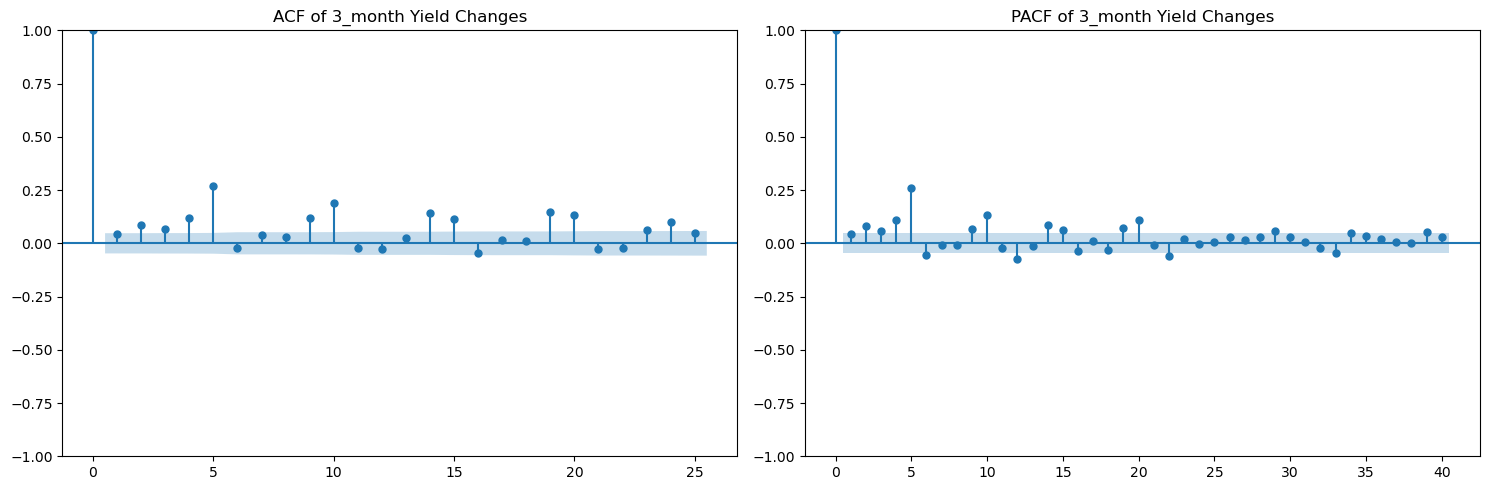

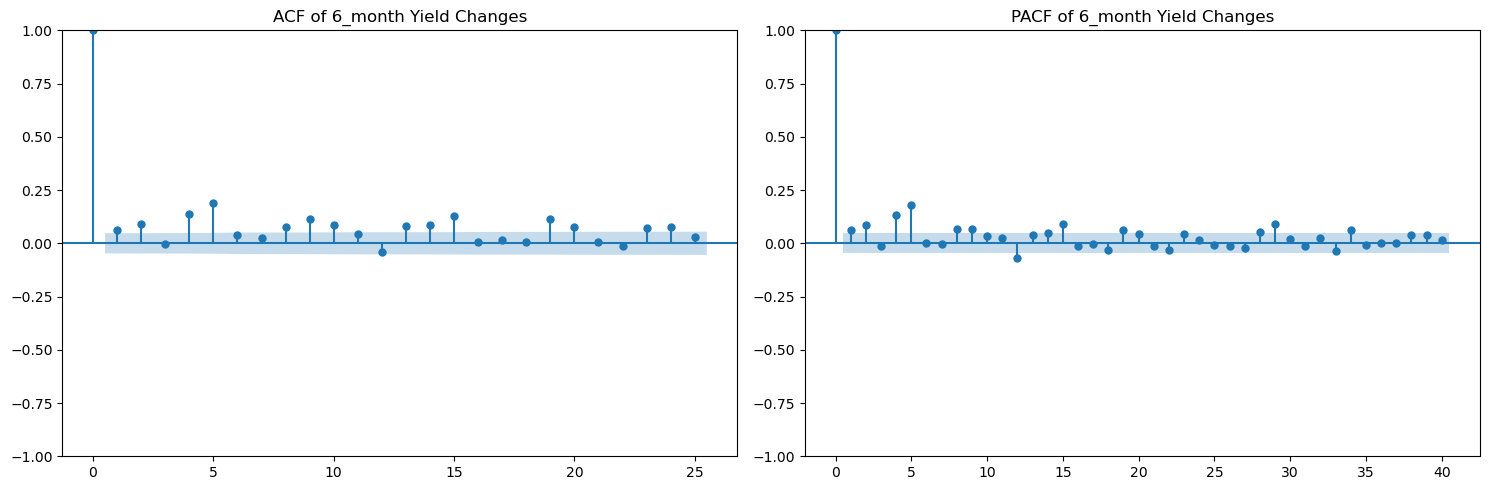

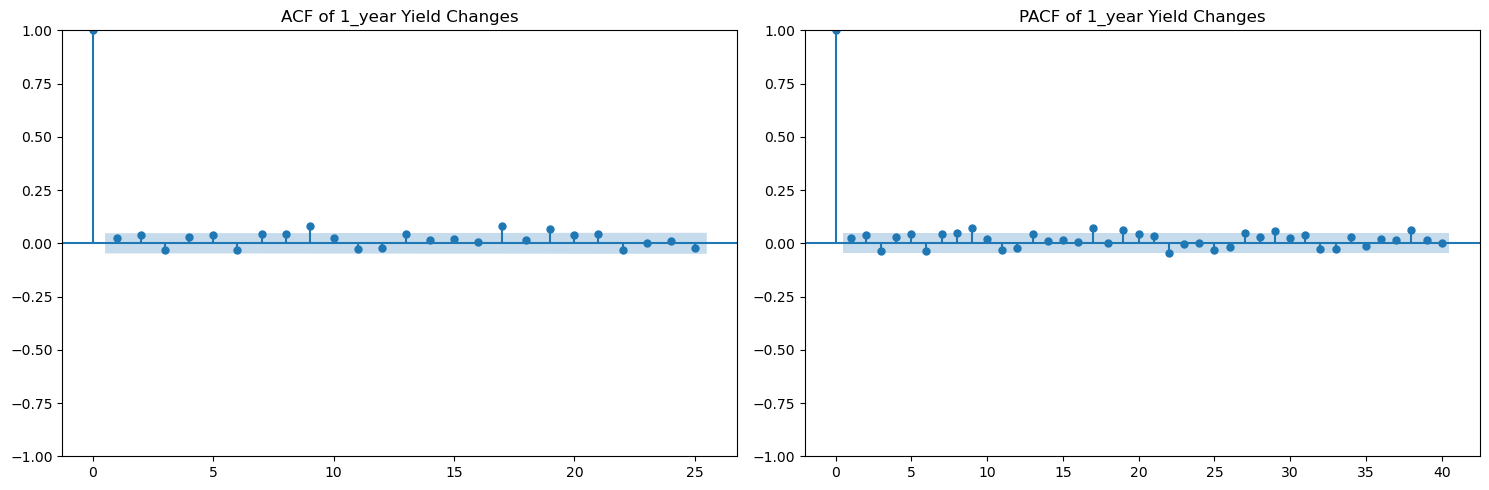

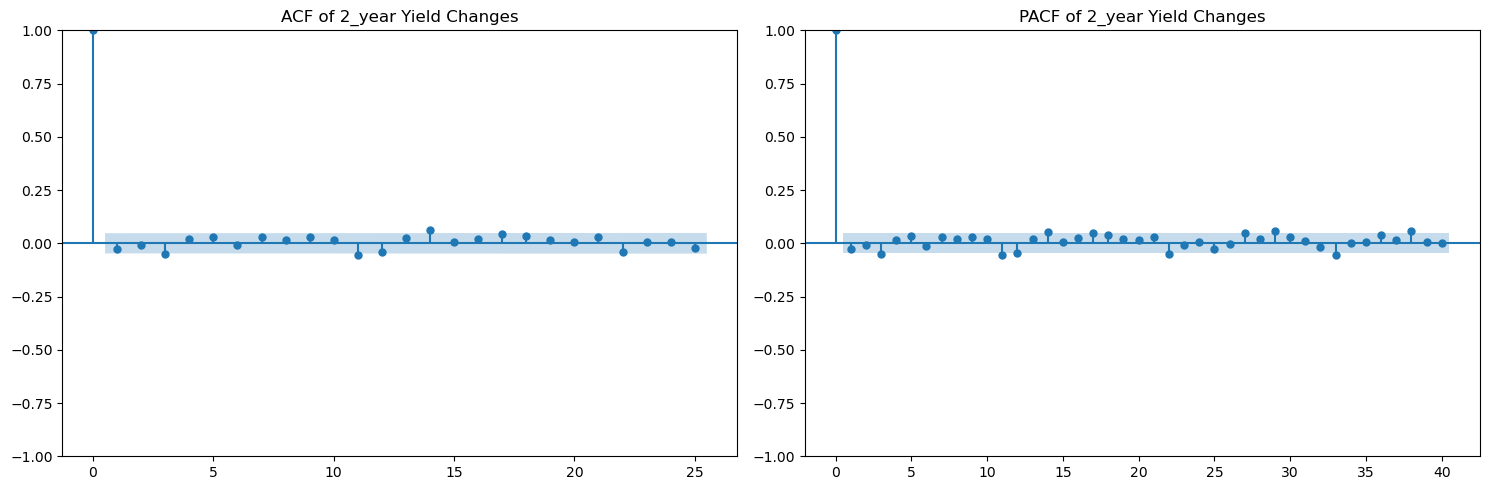

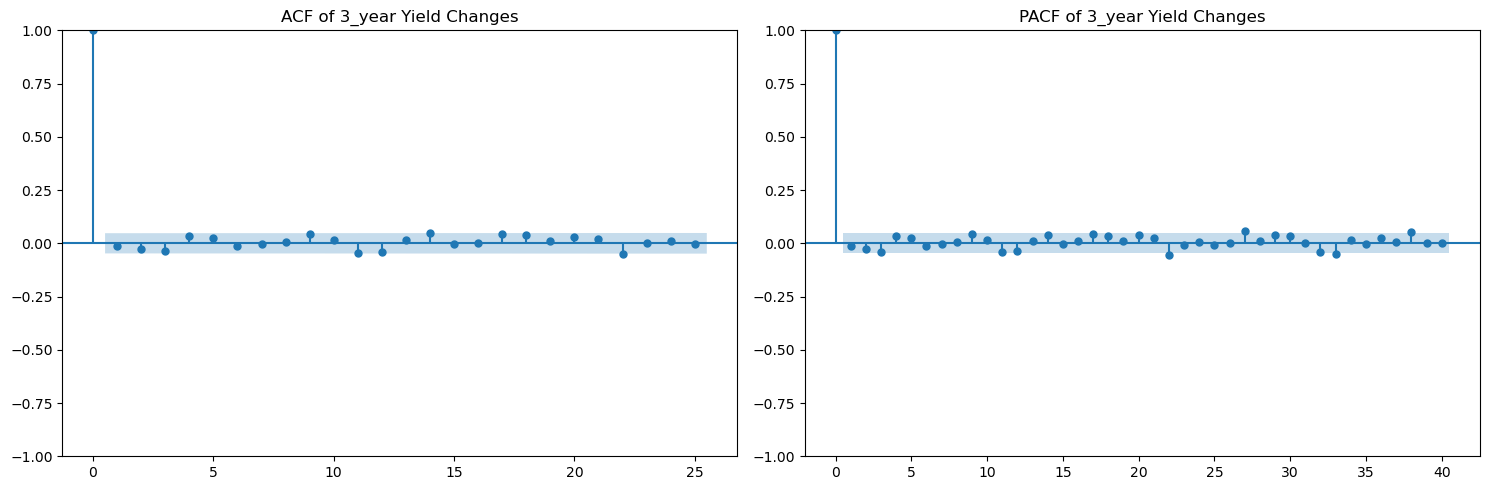

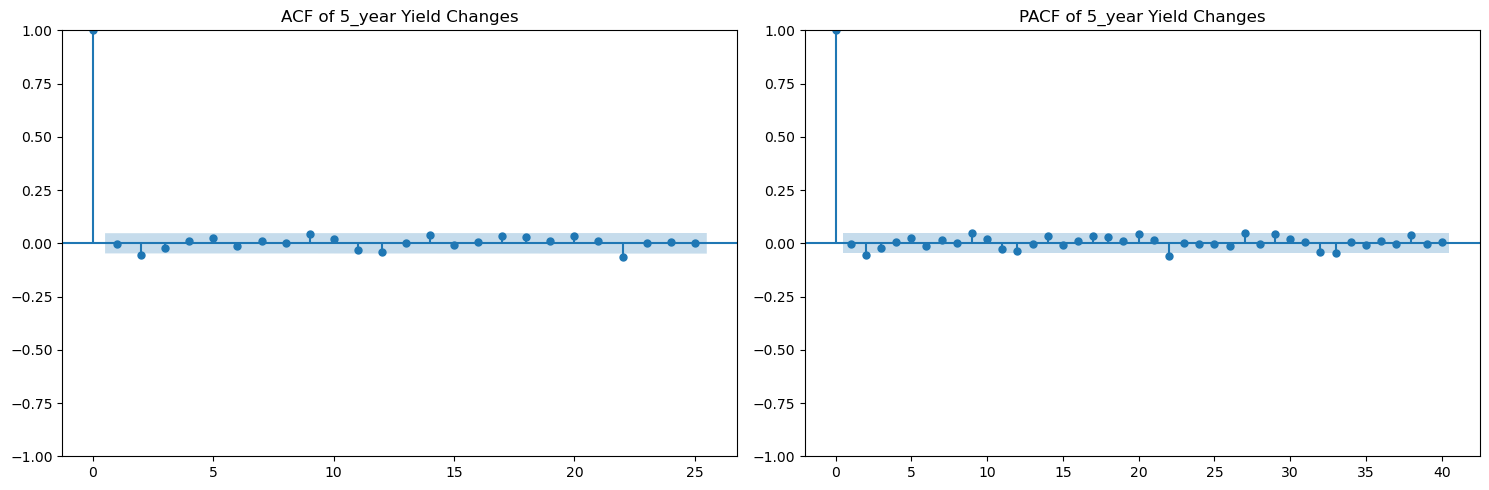

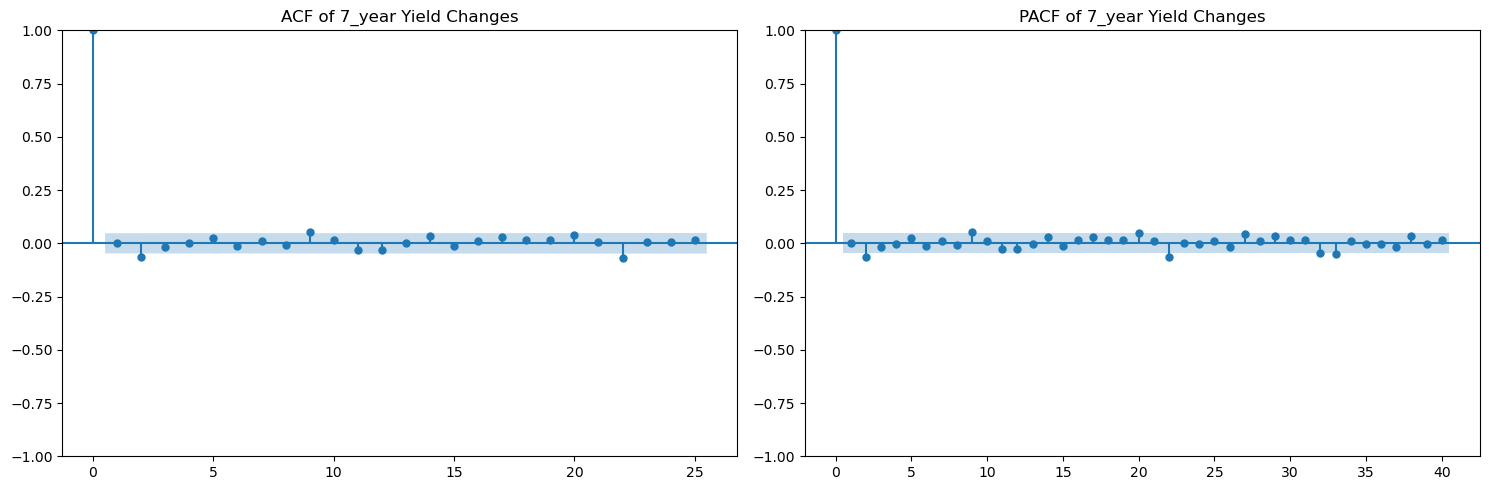

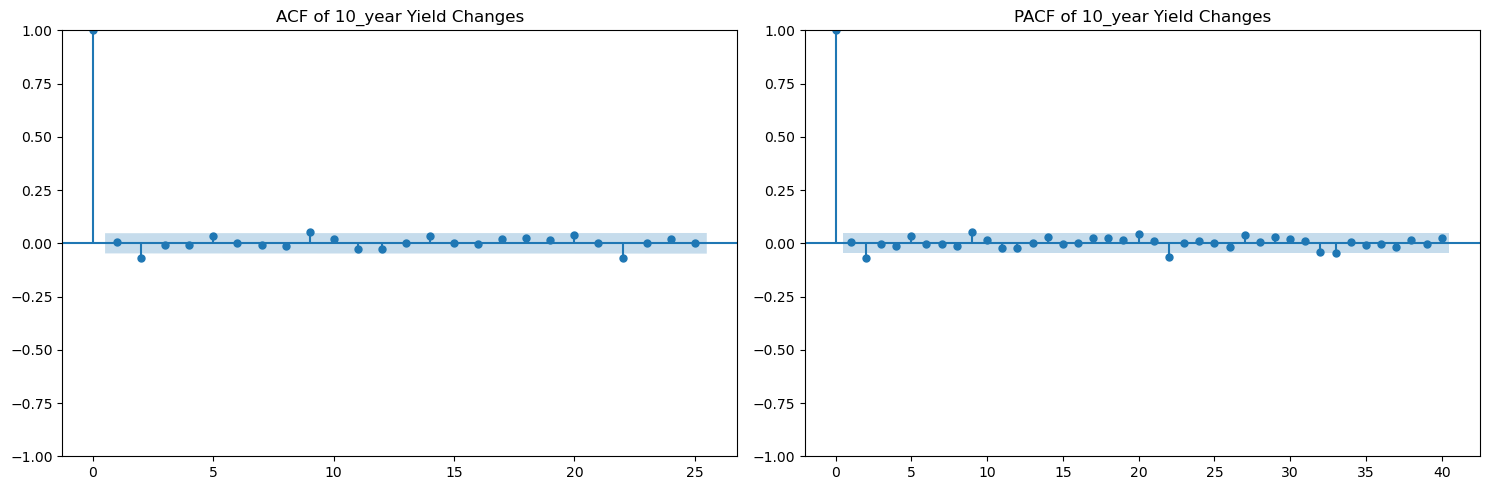

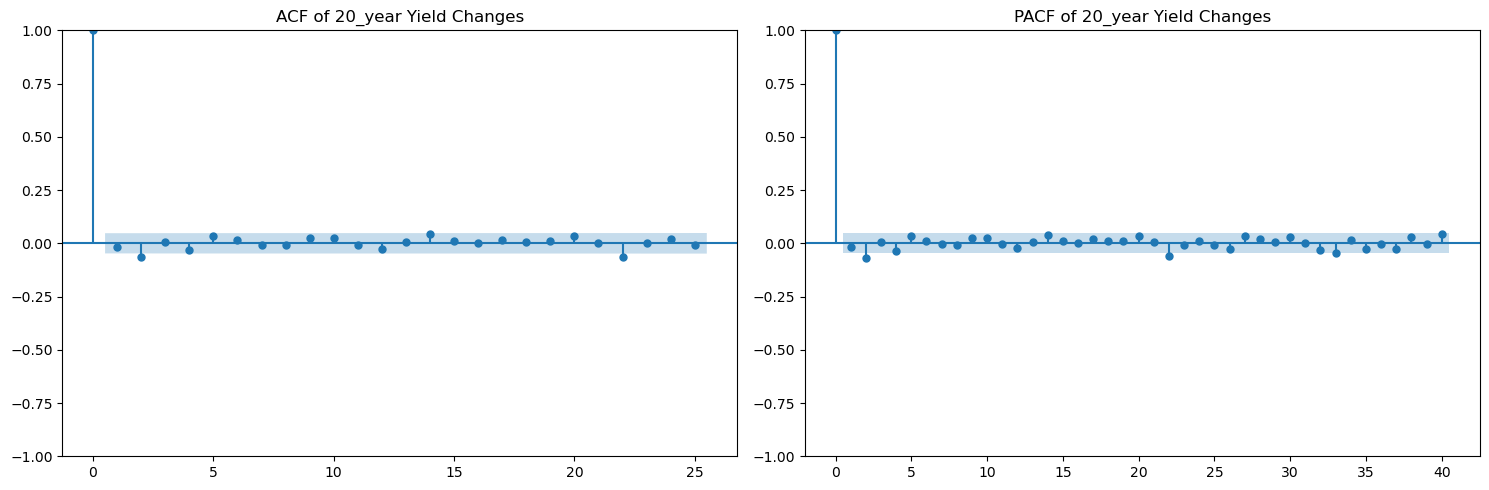

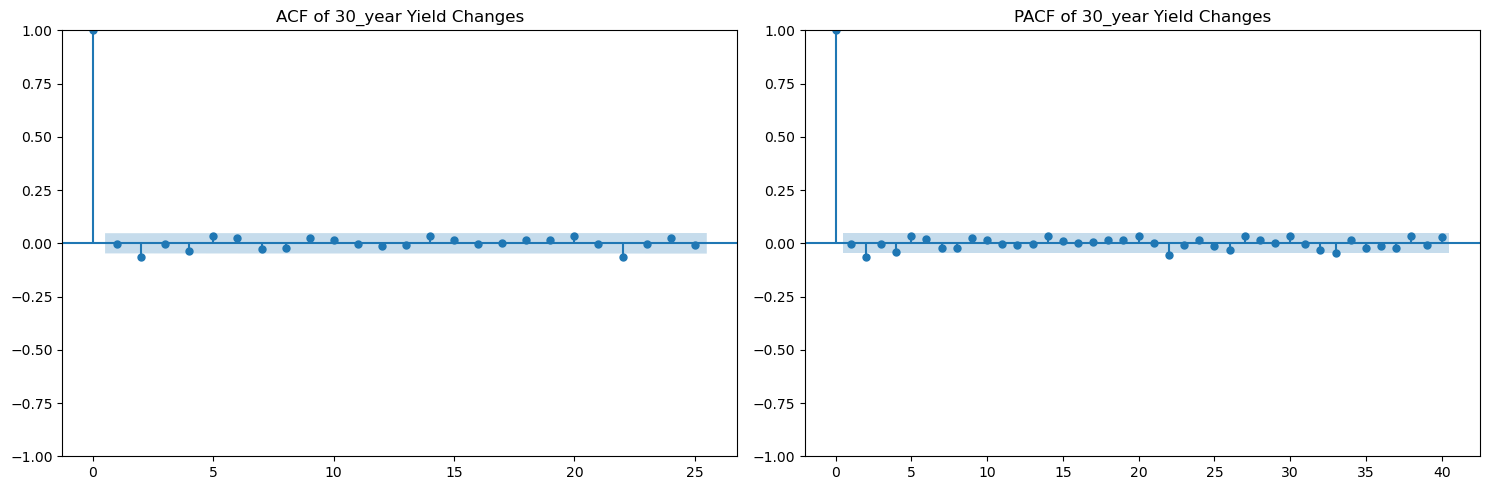

In [39]:
for term in yield_changes_df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    # Plot ACF
    plot_acf(yield_changes_df[term], lags=25, alpha=0.05, ax=axes[0])
    axes[0].set_title(f'ACF of {term} Yield Changes')

    # Plot PACF
    plot_pacf(yield_changes_df[term], lags=40, alpha=0.05, ax=axes[1])
    axes[1].set_title(f'PACF of {term} Yield Changes')

    plt.tight_layout()
    plt.show()


Insights:
<br>Short-term persistence:  
Significant drop after lag 5 in PACF indicates that yield changes are strongly correlated with their recent past (about 5 days ago).
Models like AR(5) are well-suited for capturing short-term dependence, especially for 3-month and 6-month maturities.


Implications for modeling:  
Short-term series (3M, 6M) can be effectively modeled with AR models with lag 5 to capture immediate dependencies.
Longer maturities likely exhibit less short-term autocorrelation, implying the need for models that incorporate broader factors or longer lag structures, such as multivariate models or macroeconomic regressors.

---

### 4.2 Outliers Detection & Analysis <a class="anchor" id="4b"></a>

AR and VAR models can be sensitive to outliers since they generally minimize squared errors, so large outliers might have a disproportionate influence on the estimated coefficients. In this section, we'll use z-score >= 3 as the criterion for identifying outliers, and then proceed to analysis on the identified outliers.  

In [40]:
# Use z score to idenfity outliers 
z_scores = (yield_changes_df - yield_changes_df.mean()) / yield_changes_df.std()

# Flag outliers (|z| > 3)
outlier_flags = (z_scores.abs() > 3)

In [41]:
# Count outliers per date (across all terms)
outliers_per_date = outlier_flags.sum(axis=1)

# Find dates with at least one outlier
dates_with_outliers = outliers_per_date[outliers_per_date > 0]

# Find Dates with multiple outliers
dates_with_multiple_outliers = outliers_per_date[outliers_per_date > 1]

# Output list of dates
print("Dates with at least one outlier:", list(dates_with_outliers.index))
print("Number of outliers on those dates:\n", outliers_per_date[outliers_per_date > 0])

Dates with at least one outlier: [Timestamp('2020-02-28 00:00:00'), Timestamp('2020-03-02 00:00:00'), Timestamp('2020-03-03 00:00:00'), Timestamp('2020-03-04 00:00:00'), Timestamp('2020-03-05 00:00:00'), Timestamp('2020-03-06 00:00:00'), Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-10 00:00:00'), Timestamp('2020-03-12 00:00:00'), Timestamp('2020-03-16 00:00:00'), Timestamp('2020-03-17 00:00:00'), Timestamp('2020-03-18 00:00:00'), Timestamp('2020-03-20 00:00:00'), Timestamp('2020-03-23 00:00:00'), Timestamp('2021-02-25 00:00:00'), Timestamp('2021-02-26 00:00:00'), Timestamp('2022-02-10 00:00:00'), Timestamp('2022-03-02 00:00:00'), Timestamp('2022-03-21 00:00:00'), Timestamp('2022-03-22 00:00:00'), Timestamp('2022-04-04 00:00:00'), Timestamp('2022-06-10 00:00:00'), Timestamp('2022-06-13 00:00:00'), Timestamp('2022-06-14 00:00:00'), Timestamp('2022-06-15 00:00:00'), Timestamp('2022-06-16 00:00:00'), Timestamp('2022-06-21 00:00:00'), Timestamp('2022-07-05 00:00:00'), Timestamp('202

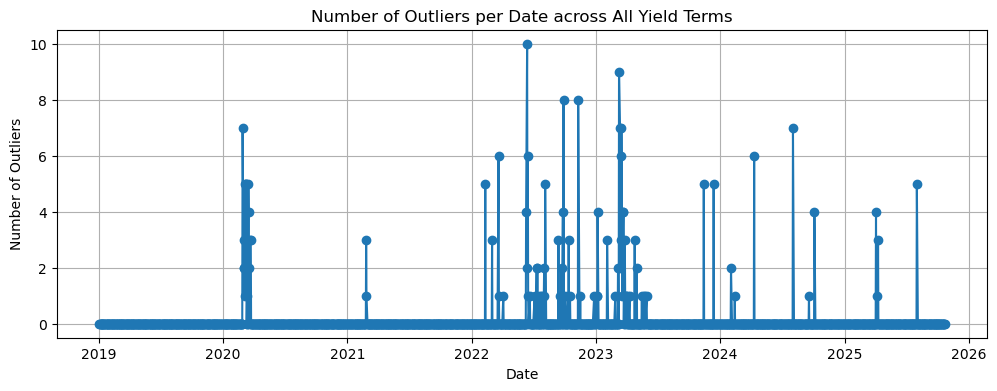

In [42]:
# Visualization: plot outlier count over time
plt.figure(figsize=(12, 4))
plt.plot(outliers_per_date.index, outliers_per_date.values, marker='o', linestyle='-')
plt.title('Number of Outliers per Date across All Yield Terms')
plt.xlabel('Date')
plt.ylabel('Number of Outliers')
plt.grid(True)
plt.show()

Insights:
- Outliers cluster in Q1 2020 and 2022–2023, reflecting major macro events. In Q1 2020, COVID-19 triggered sharp market reactions and volatility. Between 2022–2023, aggressive Fed rate hikes caused large shifts across the yield curve. 
- These outliers are not just data anomalies but represent structural shocks and regime shifts driven by macroeconomic fundamentals.
- For forecasting, it is crucial to account for these periods, either by explicitly modeling shocks (e.g., regime-switching models) or by handling outliers through winsorization or outlier-aware estimators.

---

## 5. Modeling Setup & Rolling Window Validation <a class="anchor" id="5"></a>

Since we are working with time series data, we cannot simply perform a random train-test split without risking data leakage and disrupting the temporal order. Instead, I will use a rolling window validation approach, which involves sequentially training on a fixed-size window of past data and forecasting the subsequent period. This method accurately reflects real-world forecasting scenarios and allows us to evaluate model performance and stability over different regimes.

I will use train window of 750 days (about 3 year of trading days) and a predict horizon of 120 days (about 6 month), with step size of 20 days (days to move the origin each cycle)

In [43]:
# Backtest Parameters
train_window = 750  # in days, about 3 years of trading data 
h = 120             # forecast horizon in days, about 6 month of trading data
step_size = 20      # days to move the origin each cycle

---

## 6. AR model: Modeling and Forecasting <a class="anchor" id="6"></a>

AR model

In [44]:
# Containers to store results
ar_forecasts_list = []
ar_actuals_list = []
ar_origin_dates = []

In [45]:
# Get the number of data/dates
n = len(yield_changes_df)

# Use rolling window validation, 
# Within each loop, train AR(5) on previous 750 days of data, predict the next 120 days of data, with step size of 20 days
for start_idx in range(0, n - train_window - h + 1, step_size):
    train_end_idx = start_idx + train_window
    test_end_idx = train_end_idx + h
    
    # Extract train and test data
    train_data = yield_changes_df.iloc[start_idx:train_end_idx]
    test_data = yield_changes_df.iloc[train_end_idx:test_end_idx]
    origin_date = yield_changes_df.index[train_end_idx]
    
    # Initialize DataFrame to hold forecasts
    ar_forecast_df = pd.DataFrame(index=test_data.index, columns=test_data.columns)
    
    # Loop through each term and fit AR(5)
    for term in yield_changes_df.columns:
        series = train_data[term].dropna()
        model = AutoReg(series, lags=5, old_names=False).fit()
        forecast = model.predict(start=len(series), end=len(series)+h-1, dynamic=False)
        ar_forecast_df[term] = forecast.values
    
    # Append results
    ar_forecasts_list.append(ar_forecast_df)
    ar_actuals_list.append(test_data)
    ar_origin_dates.append(origin_date)

c:\Users\yehua\anaconda3\envs\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\yehua\anaconda3\envs\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\yehua\anaconda3\envs\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\yehua\anaconda3\envs\ml_env\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit incre

In [46]:
# Convert lists to DataFrames for evaluation
ar_forecasts = pd.concat(ar_forecasts_list)
ar_actuals = pd.concat(ar_actuals_list)

In [47]:
# Compute RMSE per term
ar_rmse_per_term = np.sqrt(((ar_forecasts - ar_actuals) ** 2).mean())
print("AR(5) RMSE per term:\n", ar_rmse_per_term)


AR(5) RMSE per term:
 3_month    0.042548
6_month    0.043554
1_year     0.062409
2_year     0.078139
3_year     0.078962
5_year     0.076904
7_year     0.074653
10_year    0.068774
20_year    0.062523
30_year    0.061044
dtype: float64


In [48]:
# Create a DataFrame to store the RMSE
model_results = pd.DataFrame({'AR(5) RMSE': ar_rmse_per_term})
model_results

,AR(5) RMSE
3_month,0.042548
6_month,0.043554
1_year,0.062409
2_year,0.078139
3_year,0.078962
5_year,0.076904
7_year,0.074653
10_year,0.068774
20_year,0.062523
30_year,0.061044


In [49]:
# Compute overall RMSE (mean over all terms)
ar_overall_rmse = np.sqrt(mean_squared_error(ar_forecasts, ar_actuals))
print("Overall AR(5) RMSE:", ar_overall_rmse)

Overall AR(5) RMSE: 0.06617813531926066


---

## 7. VAR model: Modeling and Forecasting <a class="anchor" id="7"></a>

In [50]:
# Initialize containers
var_forecasts_list = []
var_actuals_list = []
var_origin_dates = []

In [51]:
# Parameters
train_window = 750  # in days
h = 120             # forecast horizon in days
step_size = 20      # days to move the origin each cycle

# Initialize containers
var_forecasts_list = []
var_actuals_list = []
var_origin_dates = []

# Get the number of data/dates
n = len(yield_changes_df)

# Use rolling window validation, 
# Within each loop, train VAR model on previous 750 days, predict the next 120 days of data, with step size of 20 days
for start_idx in range(0, n - train_window - h + 1, step_size):
    train_end_idx = start_idx + train_window
    test_end_idx = train_end_idx + h
    
    # Extract train/test subset
    train_data = yield_changes_df.iloc[start_idx:train_end_idx]
    test_data = yield_changes_df.iloc[train_end_idx:test_end_idx]
    origin_date = yield_changes_df.index[train_end_idx]
    
    # Fit VAR with lag order selection
    model = VAR(train_data)
    try:
        # try maxlags=10 first
        sel_order = model.select_order(maxlags=10)
        # Choose optimal lag based on AIC/BIC, fallback to lag=1
        lag_order = sel_order.aic or sel_order.bic
        lag_order = int(lag_order) if lag_order is not None else 1
        lag_order = max(1, min(lag_order, 10))
    except:
        lag_order = 1
    
    # Fit VAR on training data
    var_res = model.fit(lag_order)
    
    # Forecast h steps ahead
    var_forecast_array = var_res.forecast(train_data.values[-lag_order:], steps=h)
    var_forecast_df = pd.DataFrame(var_forecast_array, index=yield_changes_df.index[train_end_idx:test_end_idx], columns=yield_changes_df.columns)
    
    # Append results
    var_forecasts_list.append(var_forecast_df)
    var_actuals_list.append(test_data)


c:\Users\yehua\anaconda3\envs\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\yehua\anaconda3\envs\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\yehua\anaconda3\envs\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\yehua\anaconda3\envs\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

In [52]:
# Convert lists to DataFrames for evaluation
var_forecasts = pd.concat(var_forecasts_list)
var_actuals = pd.concat(var_actuals_list)

In [53]:
# Compute RMSE per term
var_rmse_per_term = np.sqrt(((var_forecasts - var_actuals) ** 2).mean())
print("VAR RMSE per term:\n", var_rmse_per_term)

VAR RMSE per term:
 3_month    0.042480
6_month    0.043581
1_year     0.062388
2_year     0.078162
3_year     0.078959
5_year     0.076891
7_year     0.074637
10_year    0.068753
20_year    0.062546
30_year    0.061070
dtype: float64


In [54]:
# Store the RMSE of VAR model
model_results['VAR RMSE'] = var_rmse_per_term

In [55]:
# Compute overall RMSE (mean over all terms)
var_overall_rmse = np.sqrt(mean_squared_error(var_forecasts, var_actuals))
print("Overall VAR RMSE:", var_overall_rmse)

Overall VAR RMSE: 0.06617501105682265


---

## 8. Results & Diagnostics <a class="anchor" id="8"></a>

| Model | Overall RMSE | Train Window | Prediction Horizon | Step Size | Notes |
|---------|--------------|--------------|----------------------|-----------|--------|
| AR      | 0.066178     | 750          | 120                  | 20        | p=5     |
| VAR     | 0.066175     | 750          | 120                  | 20        | lag determined by aic/bic score during each time of training     |

The RMSE for yield changes across different maturities are as follows:

In [179]:
model_results

,AR(5) RMSE,VAR RMSE
3_month,0.042548,0.042480
6_month,0.043554,0.043581
1_year,0.062409,0.062388
2_year,0.078139,0.078162
3_year,0.078962,0.078959
5_year,0.076904,0.076891
7_year,0.074653,0.074637
10_year,0.068774,0.068753
20_year,0.062523,0.062546
30_year,0.061044,0.061070


---

Visualize the forecasted yield curves alongside the actual yield data for both models.

In [187]:
# Show the first prediction
ar_forecasts.index[0]

'2021-12-31'

In [196]:
# Pick the target date to visualize, it should be later then Dec 31st 2021
# Feel free the change and play around
target_date = ('2024-04-04')

 # Get actual yields
yield_actual = yield_df.loc[target_date, :] 

In [197]:
# Get the positon of target date
pos = yield_df.index.get_loc(target_date)

In [204]:
# Get the yield changes prediction of our target date (first prediction)
ar_yield_changes_pred = ar_forecasts.loc[target_date].iloc[0, :]  
var_yield_changes_pred = var_forecasts.loc[target_date].iloc[0, :]  

In [205]:
# Add the yield changes to the original yield data
ar_yield_pred = yield_df.iloc[pos - 120, :] + ar_yield_changes_pred 
var_yield_pred = yield_df.iloc[pos - 120, :] + var_yield_changes_pred 

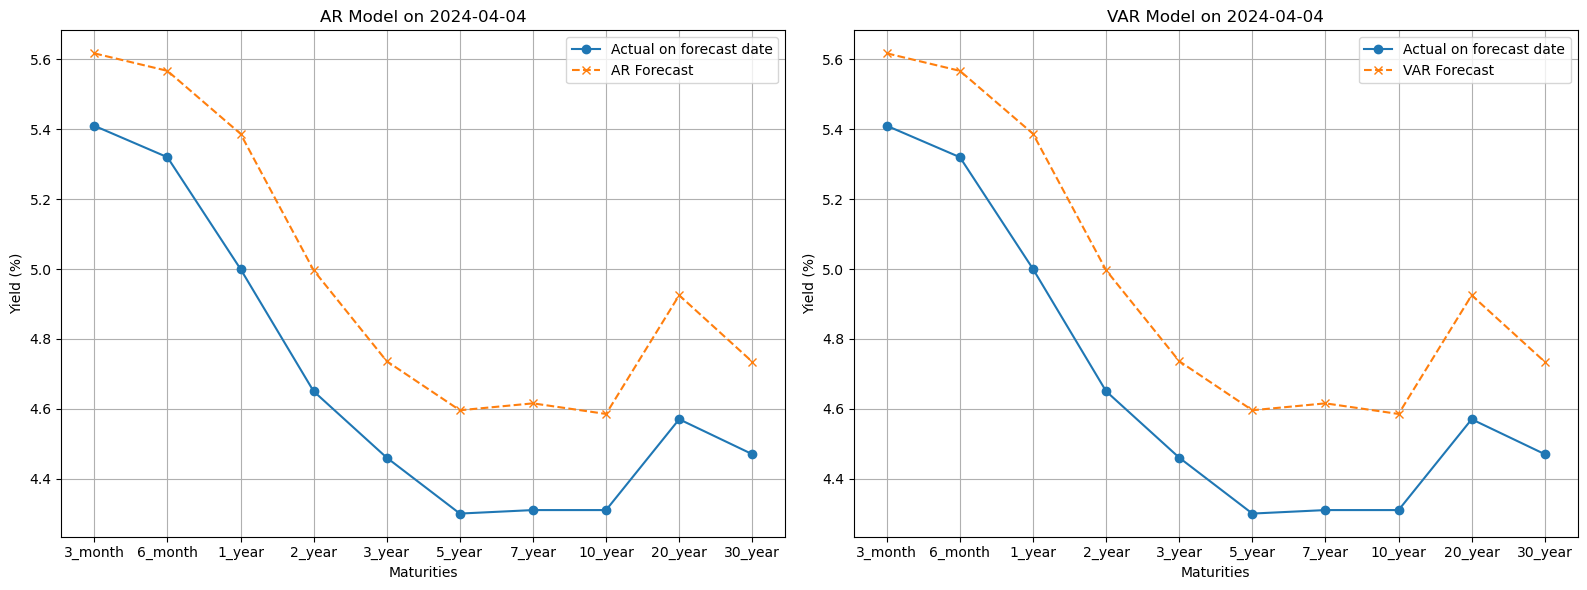

In [206]:
# Create a figure with 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for AR model
axes[0].plot(yield_df.columns, yield_actual, 'o-', label='Actual on forecast date')
axes[0].plot(yield_df.columns, ar_yield_pred, 'x--', label='AR Forecast')
axes[0].set_title(f'AR Model on {target_date}')
axes[0].set_xlabel('Maturities')
axes[0].set_ylabel('Yield (%)')
axes[0].legend()
axes[0].grid()

# Plot for VAR model
axes[1].plot(yield_df.columns, yield_actual, 'o-', label='Actual on forecast date')
axes[1].plot(yield_df.columns, var_yield_pred, 'x--', label='VAR Forecast')
axes[1].set_title(f'VAR Model on {target_date}')
axes[1].set_xlabel('Maturities')
axes[1].set_ylabel('Yield (%)')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

---

## 9. Summary & Next Steps <a class="anchor" id="9"></a>

After comparing the RMSE across different terms, the overall RMSE, and visualizations of predicted versus actual yield curves, the AR and VAR models demonstrate similar performance in terms of accuracy and predicted values. Overall, the models achieved moderate errors and reasonable predictive performance.

However, upon closer visual inspection, a consistent pattern emerges: the models tend to lag behind the actual yield changes. Specifically, during upward shifts of the yield curve, the predictions underestimate the actual increases. Conversely, during downward shifts, the models overestimate the declines. This indicates a bias where the models do not fully capture the magnitude or speed of the yield changes, particularly during periods of rapid transition.

- Next Step:
<br>Building on the insights gained from the forecasting models as well as the factor analysis using PCA, the next step is to develop a Structural Yield Curve Model using the Dynamic Nelson–Siegel (DNS) framework. This approach explicitly models the latent factors—such as the level, slope, and curvature—as dynamic time series, capturing the underlying economic and market forces that shape the yield curve.
